# Training Code
Welcome to the training code. The first thing you will want to do is to change parameters like training data location, weight storage location, epoch record location, etc. Scroll down to the section titled, "Training code for 2D spatially-varying deconvolutions" for more info.

In [1]:
%load_ext autoreload
%autoreload 2
%debug

import os, glob
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint

import matplotlib as mpl
mpl.rc('image', cmap='inferno')

import models.model_2d as mod
import forward_model_tf as fm
import utils as ut

# for resizing PSFs as appropriate:
import cv2

import load_PSFs

import sys
# sys.path.append("../data/denoising_experiments/")
sys.path.append("../common/")
import denoising

ERROR:root:No traceback has been produced, nothing to debug.


In [2]:
#!gpustat

In [3]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

os.environ["CUDA_VISIBLE_DEVICES"]="1" 

# Training code for 2D spatially-varying deconvolutions
Below, I have a whole bunch of settings for some meta-information: where PSFs are stored, where training data is stored, where to store learned weights and epoch metrics etc. The first thing you will see in the block labeled, "one setting to rule them all," is the setting of the `preset` variable. This is NOT NEEDED: if it is unset, or set to something that isn't mentioned in the block labeled, "preset definitions," all these values will be set as per the block labeled, "Default Settings". 

Otherwise, if it is set to something mentioned in "preset definitions", the values corresponding to that definition will override only those settings mentioned in the `if` block corresponding to that preset. The rest of the settings will match the default settings.

In general, I found the best-performing network to be the one labeled `noisy_5_test`. I encourage you to make a new preset by adding another `elif` statement to the preset definitions and setting the `preset` in the `one setting to rule them all` block to your newly invented preset name.

## Step 1: Create a new preset
Comment out the definition of the `preset = noisy_5_test` and add a new definition below that.
For example, paste in:
```python
preset = "my_noisy_5"
```

After this, proceed to Step 2 below.

In [4]:
# one setting to rule them all

# preset = 'single_depth_probe'
# preset = 'single_depth_probe_noisy'
# preset = 'single_depth_probe_noisy_11'
# preset = 'multiple_depths_probe'
# preset = 'probe_noisy_11_unshifted'
# preset = 'probe_noisy_11_unshifted_crazy'
# preset = 'probe_noisy_unshifted_equivariant'
preset = 'noisy_5_test'
# preset = 'new_code'

In [5]:
# Default Settings

# declare all the variables that control how the model is set up and trained.
# Point to the training data:
# target_dir = '../data/TrainingData/Ground_truth_downsampled/'  # path to objects (ground truth)
# input_dir = '../data/TrainingData/Simulated_Miniscope_2D_Training_data/'    # path to simulated measurements (inputs to deconv.)

target_dir = '../data/nV3_resized/'  # path to objects (ground truth)
# input_dir = '../data/nV3_simulated/'    # path to simulated measurements (inputs to deconv.)
# input_dir = '../data/nV3_mastermat_bare/'    # path to simulated measurements (inputs to deconv.)
input_dir = '../data/nV3_mastermat_probe_unshifted/'    # path to simulated measurements (inputs to deconv.)
# input_dir = '../data/nV3_mastermat_probe_unshifted_noisy/'
# input_dirs = ['../data/nV3_mastermat_probe_unshifted/']  
# input_dirs = ['../data/nV3_mastermat_probe_unshifted_depth1/',
#              '../data/nV3_mastermat_probe_unshifted_depth2/',
#              '../data/nV3_mastermat_probe_unshifted_depth3/']

# target_dir = '../data/TrainingData/Ground_truth_downsampled/'
# input_dir = '../data/TrainingData/Simulated_Miniscope_2D_Training_data/'

# PSF load type: could be "matlab"
# psf_loadtype = "matlab"
psf_loadtype = "csv"

# PSF locations, if psf_loadtype=="matlab"
filter_init_path = '../data/multiWienerPSFStack_40z_aligned.mat' # initialize with 9 PSFs
filter_key = 'multiWienerPSFStack_40z'  # key to load in

# multiple_psfs = False
multiple_psfs = True

# PSF directory, if psf_loadtype=="csv"
# psfs_path = '../data/nV3_PSFs'
# psfs_path = "../data/nV3_PSFs_flat_hd"
psfs_path = "../data/nV3_PSFs_probe_mark_green"
psfs_paths = ["../data/nV3_PSFs_probe_mark_green"]
# psfs_paths = ["../data/nV3_PSFs_probe_depth1/", "../data/nV3_PSFs_probe_depth2/", "../data/nV3_PSFs_probe_depth3/"]
# meta_path = '../data/nV3_PSFs_meta/PSF_Shifts.csv'
# meta_path = "../data/nV3_PSFs_flat_meta/metafile_hd.csv"
meta_path = "../data/nV3_PSFs_meta/metafile_probe_mark.csv"
meta_paths = ["../data/nV3_PSFs_probe_depths/metafile_probe_depth1.csv", \
              "../data/nV3_PSFs_probe_depths/metafile_probe_depth2.csv",
             "../data/nV3_PSFs_probe_depths/metafile_probe_depth3.csv"]

# Pixel size of the images we're dealing with. This must be the same as the desired PSF size. 
# Program will adjust size of PSFs by linear interpolation as needed, but will only crop images.
# img_dims is (width, height)
img_dims = (1280, 800)
# img_dims = (648, 486)

# choose network type to train
model_type='multiwiener' # choices are 'multiwiener', 'wiener', 'unet'

# IMPORTANT! CHANGE WHEN NEEDED!
# where to store weights and training info
# training_location = "saved_models/multiwiener_nV3_bare/model_weights"
# epochlog_location = "saved_models/multiwiener_nV3_bare/epoch.log"
# training_location = "saved_models/multiwiener_nV3_probe/model_weights"
training_location = "saved_models/multiwiener_nV3_probe_depths/model_weights"
# epochlog_location = "saved_models/multiwiener_nV3_probe/epoch.log"
epochlog_location = "saved_models/multiwiener_nV3_probe_depths/epoch.log"
# training_location = "saved_models/waller/model_weights"
# epochlog_location = "saved_models/waller/epoch.log"

# legacy_training decides whether to use the old way of training, with GradientTape etc
# or the more standard model.fit() approach.
# The former was used by the original Waller code, but seems to work better.
legacy_training = True
smallset = False # if True, will train on a small subset of the dataset to make things a bit faster.
backup_location = None

## Step 2: Define the preset used above
At the bottom of the "preset definitions" block below, paste in something like the following:
```python
elif preset == 'my_noisy_5':
    multiple_psfs = False
    target_dir = '../data/nV3_resized/'  # path to objects (ground truth)
    input_dir = '../data/my_psfs/'    # path to simulated measurements (inputs to deconv.)
    training_location = "saved_models/my_noisy_5/model_weights"
    epochlog_location = "saved_models/my_noisy_5/epoch.log"
    crazy_external_noise_addition = True
    training_noise_sigma=11/255
    pooling='average'
```

The line defining `input_dir` sets the path to the simulated images.

The line defining `training_location` defines where the model weights will be stored.

The line defining `epochlog_location` defines where the log of the present epoch should be stored.

`crazy_external_noise_addition` enables the bahaviour used during training of the most successful model, where the background of the ground truth images was boosted by the mean of the added Gaussian noise.

`training_noise_sigma` defines the standard deviation of the added Gaussian noise

`pooling` defines the type of pooling layer to use. This can be `average`, `max`, `averageblur` or `maxblur`. The last two are implementations of the BlurPool layers introduced by [(Zhang, 2019)](https://arxiv.org/abs/1904.11486).

The name, i.e. `my_noisy_5` should match the preset you set in Step 1.

In [6]:
# preset definitions

if preset == 'single_depth_probe':
    multiple_psfs = False
    target_dir = '../data/nV3_resized/'  # path to objects (ground truth)
#     input_dir = '../data/nV3_mastermat_probe_unshifted/'    # path to simulated measurements (inputs to deconv.)
    psfs_path = "../data/nV3_PSFs_probe_mark_green"
    training_location = "saved_models/multiwiener_nV3_probe/model_weights"
    epochlog_location = "saved_models/multiwiener_nV3_probe/epoch.log"
if preset == 'single_depth_probe_noisy':
    multiple_psfs = False
    target_dir = '../data/nV3_resized/'  # path to objects (ground truth)
    input_dir = '../data/nV3_mastermat_probe_unshifted/'    # path to simulated measurements (inputs to deconv.)
#     input_dir = '../data/nV3_mastermat_probe_unshifted_noisy/'
#     input_dir = '../data/nV3_mastermat_probe_unshifted/' # temporary, since we are adding noise on training
    psfs_path = "../data/nV3_PSFs_probe_mark_green"
    training_location = "saved_models/multiwiener_nV3_probe_noisy2/model_weights"
    epochlog_location = "saved_models/multiwiener_nV3_probe_noisy2/epoch.log"
    training_noise_sigma=4.2
elif preset == 'multiple_depths_probe':
    multiple_psfs = True
    target_dir = '../data/nV3_resized/'  # path to objects (ground truth)
    input_dirs = ['../data/nV3_mastermat_probe_unshifted_depth1/',
             '../data/nV3_mastermat_probe_unshifted_depth2/',
             '../data/nV3_mastermat_probe_unshifted_depth3/']
    psfs_paths = ["../data/nV3_PSFs_probe_depth1/", 
                  "../data/nV3_PSFs_probe_depth2/", 
                  "../data/nV3_PSFs_probe_depth3/"]
    training_location = "saved_models/multiwiener_nV3_probe_depths/model_weights"
    epochlog_location = "saved_models/multiwiener_nV3_probe_depths/epoch.log"
elif preset == 'single_depth_probe_noisy_11':
    # noisy with a standard deviation of 11, as observed
    multiple_psfs = False
    target_dir = '../data/nV3_resized/'  # path to objects (ground truth)
    input_dir = '../data/nV3_mastermat_probe_unshifted/'    # path to simulated measurements (inputs to deconv.)
#     input_dir = '../data/nV3_mastermat_probe_unshifted_noisy/'
#     input_dir = '../data/nV3_mastermat_probe_unshifted/' # temporary, since we are adding noise on training
    psfs_path = "../data/nV3_PSFs_probe_mark_green"
    training_location = "saved_models/multiwiener_nV3_probe_noisy3/model_weights"
    epochlog_location = "saved_models/multiwiener_nV3_probe_noisy3/epoch.log"
    training_noise_sigma=11/255
elif preset == 'probe_noisy_11_unshifted':
    # noisy with a standard deviation of 11, as observed
    multiple_psfs = False
    target_dir = '../data/nV3_resized/'  # path to objects (ground truth)
    input_dir = '../data/nV3_mastermat_probe_undistorted_corrected/'    # path to simulated measurements (inputs to deconv.)
#     input_dir = '../data/nV3_mastermat_probe_unshifted_noisy/'
#     input_dir = '../data/nV3_mastermat_probe_unshifted/' # temporary, since we are adding noise on training
    psfs_path = "../data/nV3_PSFs_probe_mark_green"
    training_location = "saved_models/multiwiener_nV3_probe_noisy4/model_weights"
    epochlog_location = "saved_models/multiwiener_nV3_probe_noisy4/epoch.log"
    training_noise_sigma=11/255
elif preset == 'probe_noisy_11_unshifted_crazy':
    # noisy with a standard deviation of 11, as observed
    multiple_psfs = False
    target_dir = '../data/nV3_resized/'  # path to objects (ground truth)
    input_dir = '../data/nV3_mastermat_probe_undistorted_corrected/'    # path to simulated measurements (inputs to deconv.)
#     input_dir = '../data/nV3_mastermat_probe_unshifted_noisy/'
#     input_dir = '../data/nV3_mastermat_probe_unshifted/' # temporary, since we are adding noise on training
    psfs_path = "../data/nV3_PSFs_probe_mark_green"
    training_location = "saved_models/multiwiener_nV3_probe_noisy5/model_weights"
    epochlog_location = "saved_models/multiwiener_nV3_probe_noisy5/epoch.log"
    crazy_external_noise_addition = True
    training_noise_sigma=11/255
    pooling='average'
elif preset == 'probe_noisy_unshifted_equivariant':
    # noisy with a standard deviation of 11, as observed
    multiple_psfs = False
    target_dir = '../data/nV3_resized/'  # path to objects (ground truth)
    input_dir = '../data/nV3_mastermat_probe_undistorted_corrected/'    # path to simulated measurements (inputs to deconv.)
#     input_dir = '../data/nV3_mastermat_probe_unshifted_noisy/'
#     input_dir = '../data/nV3_mastermat_probe_unshifted/' # temporary, since we are adding noise on training
    psfs_path = "../data/nV3_PSFs_probe_mark_green"
    training_location = "saved_models/multiwiener_nV3_probe_equivariant/model_weights"
    epochlog_location = "saved_models/multiwiener_nV3_probe_equivariant/epoch.log"
#     pooling = 'maxblur'
    pooling = 'averageblur'
    crazy_external_noise_addition = True
    training_noise_sigma=11/255
elif preset == 'noisy_5_test':
    # noisy with a standard deviation of 11, as observed
    multiple_psfs = False
    target_dir = '../data/nV3_resized/'  # path to objects (ground truth)
    input_dir = '../data/nV3_mastermat_probe_undistorted_corrected/'    # path to simulated measurements (inputs to deconv.)
#     input_dir = '../data/nV3_mastermat_probe_unshifted_noisy/'
#     input_dir = '../data/nV3_mastermat_probe_unshifted/' # temporary, since we are adding noise on training
    psfs_path = "../data/nV3_PSFs_probe_mark_green"
    training_location = "saved_models/noisy_5_test/model_weights"
    epochlog_location = "saved_models/noisy_5_test/epoch.log"
    crazy_external_noise_addition = True
    training_noise_sigma=11/255
    pooling='average'
elif preset == 'new_code':
    # noisy with a standard deviation of 11, as observed
    multiple_psfs = False
    target_dir = '../data/nV3_resized/'  # path to objects (ground truth)
    input_dir = '../data/nV3_mastermat_probe_undistorted_corrected/'    # path to simulated measurements (inputs to deconv.)
#     input_dir = '../data/nV3_mastermat_probe_unshifted_noisy/'
#     input_dir = '../data/nV3_mastermat_probe_unshifted/' # temporary, since we are adding noise on training
    psfs_path = "../data/nV3_PSFs_probe_mark_green"
#     training_location = "saved_models/multiwiener_nV3_probe_noisy5_new_way/model_weights"
    training_location = "saved_models/multiwiener_nV3_probe_noisy5_new_way2/model_weights"
#     epochlog_location = "saved_models/multiwiener_nV3_probe_noisy5/epoch.log"
    crazy_external_noise_addition = True
    training_noise_sigma=11/255
    pooling='average'
    legacy_training = False
    smallset=True
    backup_location = "saved_models/multiwiener_nV3_probe_noisy5_new_way2/backup"

## Step 3: Run the notebook
Now, you should be good to run the entire notebook! Press the "Restart, and run all" button at the top of this window.

This should take you down to the training block. Above this block is Step 4, which details how to stop training.

In [7]:
# multiple_psfs = True

In [8]:
input_dirs = [input_dir]

## Make dataset and dataloader for training data

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
batch_size = 1
# batch_size = 2
# batch_size=3

In [10]:

if multiple_psfs:
    target_path = (sorted(glob.glob(target_dir + '*')))*len(input_dirs)
    input_path_lists = [(sorted(glob.glob(input_dir + '*'))) for input_dir in input_dirs]
    input_path = []
    for pathset in input_path_lists:
        for path in pathset:
            input_path.append(path)
else:
    input_path = sorted(glob.glob(input_dir + '*'))
    target_path = sorted(glob.glob(target_dir + '*'))

image_count=len(os.listdir(target_dir))
print(image_count) 

22126


In [11]:
len(input_path)

22126

In [12]:
len(target_path)

22126

In [13]:
target_path[-1]

'../data/nV3_resized/9999.png'

In [14]:
# input_path_lists[1]

In [15]:
# input_path[-1]

In [16]:
# Create a first dataset of file paths and labels
dataset = tf.data.Dataset.from_tensor_slices((input_path, target_path))
dataset = dataset.shuffle(image_count, seed=0, reshuffle_each_iteration=False)


# Split into train/validation
if smallset:
    val_size = int(5)
    train_ds = dataset.skip(val_size).take(20)
else:
    val_size = int(image_count * 0.25)
    # took a small number of samples for test training to make epochs go faster
    train_ds = dataset.skip(val_size)
#train_ds = dataset.skip(val_size).take(100)

    
val_ds = dataset.take(val_size)

print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

train_ds = train_ds.map(ut.parse_function, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(ut.parse_function, num_parallel_calls=AUTOTUNE)

train_ds = ut.configure_for_performance(train_ds,batch_size)
val_ds = ut.configure_for_performance(val_ds,batch_size)

print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

16595
5531
16595
5531


In [17]:
# for x, y in train_ds:
#     print("x has shape: ", x.shape)
#     print("y has shape: ", y.shape)

In [18]:
# import imageio
# plt.imshow(imageio.imread('../data/nV3_mastermat_bare/1079.png'))

In [19]:
# train_ds.get_single_element?

In [20]:
#visualzie data to make sure all is good
# import pdb
# pdb.set_trace()
# input_batch, target_batch = next(iter(val_ds))
# f, ax = plt.subplots(1, 2, figsize=(15,15))

# ax[0].imshow(input_batch[0,:,:,0] + np.random.normal(scale=training_noise_sigma, size=input_batch[0,:,:,0].shape), vmax = 1)
# ax[0].set_title('Input Data')

# ax[1].imshow(target_batch[0,:,:,0], vmax = 1)
# ax[1].set_title('Target Data')

# print(input_batch[0,:,:,0].shape)

In [21]:
# np.max(input_batch[0,:,:,0])

In [22]:
# type(input_batch)

In [23]:
# for path in input_path:
#     try:
#         print(path)
#         imageio.imread(path)
#     except:
#         print("BROKEN: " + path)

In [24]:
# type(train_ds)

# load in Psfs and initialize network to train

Here we initialize with 9 PSFs taken from different parts in the field of view

In [25]:
import sys
sys.path.append("../common")
import csv_psfs
# from IPython.core.debugger import set_trace

# load the PSFs
if psf_loadtype == "matlab":
    registered_psfs_path = filter_init_path
    psfs = scipy.io.loadmat(registered_psfs_path)
    psfs=psfs[filter_key]
elif psf_loadtype == "csv":
#     # expect a directory with a bunch of PSFs therein as separate csvs;
#     # list out all csv file names in the directory
#     psf_paths = glob.glob(psfs_path.removesuffix('/') + '/*')
#     # iterate through that list,
#     # open and append each to the psfs array,
#     psfs = [[]]
#     for path in psf_paths:
#         #psfs[0].append(np.loadtxt(path, delimiter=',', encoding='utf-8-sig'))
#         psfs[0].append(np.loadtxt(path, delimiter=','))
#     # convert the psfs array to an np.ndarray
#     psfs = np.transpose(np.asarray(psfs), (2,3,1,0))
#     set_trace()
##     psfs = load_PSFs.load_PSFs_csv(psfs_path, meta_path, img_dims)[:,:,:,0]
#     if not multiple_psfs: 
#         psfs = csv_psfs.pad_as_center(csv_psfs.load_from_dir(psfs_path), img_dims[1], img_dims[0])

# handle multiple sets of PSFs:
    # FIXME: magic number 63 is 3*the number of PSFs per metafile
    if multiple_psfs:
        psfs = np.empty((img_dims[1], img_dims[0], 21*3))
        for i in range(len(psfs_paths)):
            psfs[:,:,i:i+21] = csv_psfs.pad_as_center(csv_psfs.load_from_dir(psfs_paths[i]), img_dims[1], img_dims[0])
    else:
        psfs = csv_psfs.pad_as_center(csv_psfs.load_from_dir(psfs_path), img_dims[1], img_dims[0])
else:
    raise ValueError("Not sure how to load PSFs")
psfs.shape

# for testing, cut the psf and look at padding behaviour
#psfs = psfs[162:324, 216:432, :, :]
#psfs.shape
# Test result: it works!!!

(800, 1280, 21)

In [26]:
psfs.shape

(800, 1280, 21)

## Examine the PSFs

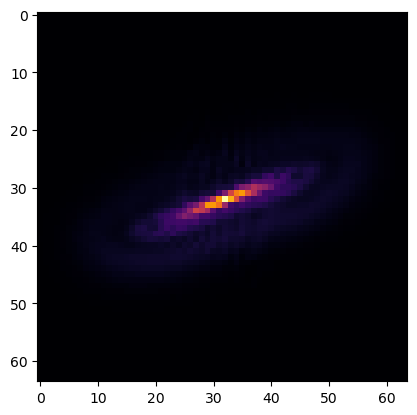

In [27]:
ind = 10
plt.imshow(psfs[368:432,608:672,ind])

From the above, it seems that the PSFs indeed start out centered. This means that something happens during training to cause them to shift around. I wonder if it's possible that the model I've been interrogating was trained on distorted data (that would explain this)

In [28]:
# type(psfs_paths) == list

In [29]:
type("string") == str

True

In [30]:
psfs.shape

(800, 1280, 21)

In [31]:
# set_trace()

if model_type=='unet':
    model =mod.UNet(486, 648, 
                             encoding_cs=[24, 64, 128, 256, 512, 1024],
                             center_cs=1024,
                             decoding_cs=[512, 256, 128, 64, 24, 24],
                             skip_connections=[True, True, True, True, True, False])
elif model_type=='wiener':

    registered_psfs_path = filter_init_path
    psfs = scipy.io.loadmat(registered_psfs_path)
    psfs=psfs[filter_key]
    psfs=psfs[:,:,0,0]
    psfs=psfs/np.max(psfs)
    
    Ks=1

    model = mod.UNet_wiener(486, 648, psfs, Ks, 
                             encoding_cs=[24, 64, 128, 256, 512, 1024],
                             center_cs=1024,
                             decoding_cs=[512, 256, 128, 64, 24, 24],
                             skip_connections=[True, True, True, True, True, False])
    
    print(psfs.shape, 1)
    
elif model_type=='multiwiener':
    # assume psfs is already 3-dimensional if our PSFs are used
    # if matlab-style is used, it's typically an academic who likes 4D
    if psf_loadtype == "matlab":
        psfs=psfs[:,:,:,0]
    print(psfs.shape)
    #psfs = cv2.resize(psfs, img_dims)
    # rather than resizing, zero-pad to appropriate size
    # this means that original PSF can be any size, but Image Delta must be set correctly
    
    print(psfs.shape)
    psfs=psfs/np.max(psfs)
    if multiple_psfs:
        psfs_keep = psfs[:,:,list(range(0,11))+list(range(21,32))+list(range(43,54))]*1
#         psfs_keep = psfs*1
    #     psfs_keep = psfs[:,:,list(range(0,11))+list(range(21,32))]*1
    #     psfs_keep = psfs[:,:,0:21]*1
        print(psfs_keep.shape)

    #     Ks =np.ones((1,1,psfs.shape[2]))
        Ks_keep = np.ones((1,1,psfs_keep.shape[2]))
        print(Ks_keep.shape)

        model =mod.UNet_multiwiener_resize(img_dims[1], img_dims[0], psfs_keep, Ks_keep, 
                             encoding_cs=[24, 64, 128, 256, 512, 1024],
                             center_cs=1024,
                             decoding_cs=[512, 256, 128, 64, 24, 24],
                             skip_connections=[True, True, True, True, True, False], psfs_trainable=True)
#     model =mod.UNet_multiwiener_resize(img_dims[1], img_dims[0], psfs, Ks, 
#                          encoding_cs=[24, 64, 128, 256, 512, 1024],
#                          center_cs=1024,
#                          decoding_cs=[512, 256, 128, 64, 24, 24],
#                          skip_connections=[True, True, True, True, True, False])

# made PSFs untrainable
    else:
        Ks =np.ones((1,1,psfs.shape[2]))
        model =mod.UNet_multiwiener_resize(img_dims[1], img_dims[0], psfs, Ks, 
                             encoding_cs=[24, 64, 128, 256, 512, 1024],
                             center_cs=1024,
                             decoding_cs=[512, 256, 128, 64, 24, 24],
                             skip_connections=[True, True, True, True, True, False], psfs_trainable=True,
                                training_noise=True,
                                training_noise_sigma=training_noise_sigma,
                                pooling=pooling)
#     model =mod.UNet_multiwiener_resize(img_dims[1], img_dims[0], psfs_keep, Ks_keep, 
#                          encoding_cs=[24, 64, 128, 256, 512, 1024],
#                          center_cs=1024,
#                          decoding_cs=[512, 256, 128, 64, 24, 24],
#                          skip_connections=[True, True, True, True, True, False], psfs_trainable=True)
    
#     print('initialized filter shape:', psfs.shape, 'initialized K shape:', Ks.shape)
# print('initialized filter shape:', psfs_keep.shape, 'initialized K shape:', Ks_keep.shape)

(800, 1280, 21)
(800, 1280, 21)


In [32]:
list(range(10))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [33]:
psfs.shape

(800, 1280, 21)

In [34]:
if legacy_training:
    model.build((None, img_dims[1], img_dims[0], 1))

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 800, 1280,   0           []                               
                                1)]                                                               
                                                                                                  
 gaussian_noise (GaussianNoise)  (None, 800, 1280, 1  0          ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 multi_wiener_deconvolution (Mu  (None, 800, 1280, 2  21504021   ['gaussian_noise[0][0]']         
 ltiWienerDeconvolution)        1)                                                            

                                                                                                  
 conv2d_7 (Conv2D)              (None, 100, 160, 25  589824      ['activation_6[0][0]']           
                                6)                                                                
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 100, 160, 25  1024       ['conv2d_7[0][0]']               
 rmalization)                   6)                                                                
                                                                                                  
 activation_7 (Activation)      (None, 100, 160, 25  0           ['batch_normalization_7[0][0]']  
                                6)                                                                
                                                                                                  
 average_p

 ormalization)                                                                                    
                                                                                                  
 activation_15 (Activation)     (None, 25, 40, 512)  0           ['batch_normalization_15[0][0]'] 
                                                                                                  
 tf.image.resize_1 (TFOpLambda)  (None, 50, 80, 512)  0          ['activation_15[0][0]']          
                                                                                                  
 concatenate_1 (Concatenate)    (None, 50, 80, 1024  0           ['tf.image.resize_1[0][0]',      
                                )                                 'activation_9[0][0]']           
                                                                                                  
 conv2d_16 (Conv2D)             (None, 50, 80, 256)  2359296     ['concatenate_1[0][0]']          
          

                                                                                                  
 activation_23 (Activation)     (None, 200, 320, 64  0           ['batch_normalization_23[0][0]'] 
                                )                                                                 
                                                                                                  
 conv2d_24 (Conv2D)             (None, 200, 320, 64  36864       ['activation_23[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_24 (BatchN  (None, 200, 320, 64  256        ['conv2d_24[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 activatio

Total params: 68,688,742
Trainable params: 68,672,614
Non-trainable params: 16,128
__________________________________________________________________________________________________


In [35]:
#tf.config.list_physical_devices()

In [36]:
# np.any(np.isnan(psfs_keep))

# Train

In [37]:
indicator_reshaped = tf.convert_to_tensor(np.load("../data/fov_indicator.npy").reshape((1,800,1280,1)), dtype=tf.float32)
# indicator_reshaped = tf.convert_to_tensor(np.load("../data/fov_indicator.npy"), dtype=tf.float32)

In [38]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [39]:
# train_ds.unbatch?

## Step 4: Monitor, stop training
If you followed Step 3 correctly, the block below should already be running. It may take a few seconds to a minute to get itself together, and then it will print out the current training status below.

That current training status will tell you the current epoch as well as the current "step"--the latter is which image or batch you are currently on.

When you decide that you want to stop training, you can press the button with the square on it at the top of this window (the "interrupt kernel" button). Keep in mind that this will only save the last completed epoch, and any training done on the present epoch will be lost.

After doing this, you can proceed to the cells below, or else move onto another notebook, e.g. `Minimal Deconvolution.ipynb`. The latter is the preferred method, since that notebook is made much more user-friendly than everything else I've done here.

In [40]:
# ADDED BY DANIEL:
# Prepare EpochLogger and load weights, if necessary, into the model
# %debug
# set_trace()
import epochlog.epochlog as el
print("done all the crap")

## Training with TF.Dataset
initial_learning_rate = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False) #1e-3 diverges

# what's the expected input shape for the model?
exp_shape = model.get_config()["layers"][0]["config"]["batch_input_shape"]
print(exp_shape)

# Keep results for plotting
train_loss_results = []
train_accuracy_results = []
validtate_loss_results=[]
num_epochs = 100
loss_func=ut.SSIMLoss_l1_indicator
learning_rate_counter=0
#for epoch in range(num_epochs):
if legacy_training:
    epochlogger = el.EpochLogger(model, epochlog_location, training_location)
    epochlogger.load_weights()
    starting_epoch = epochlogger.epochs_done()
    print("Starting on epoch number: " + str(starting_epoch))
    for epoch in range(starting_epoch, num_epochs):
        validation_loss_avg=tf.keras.metrics.Mean()
        epoch_loss_avg = tf.keras.metrics.Mean()
        epoch_accuracy = tf.keras.metrics.MeanSquaredError()

        # Training loop
        iter_num=0
        for x, y in train_ds:
            # Optimize the model
            #print("x shape: " + str(x.shape))
            #print("y shape: " + str(y.shape))
            # NOTICE: x.shape = y.shape = (2, 486, 648, 1)
            # TODO: resize x and y based on expected dimensions for the model
            # Crop to the top left corner of the image to make it fit our size if it is too large
            if x.shape[1] > exp_shape[1]:
                x = x[:,:exp_shape[1],:,:]
            if x.shape[2] > exp_shape[2]:
                x = x[:,:,:exp_shape[2],:]
            if y.shape[1] > exp_shape[1]:
                y = y[:,:exp_shape[1],:,:]
            if y.shape[2] > exp_shape[2]:
                y = y[:,:,:exp_shape[2],:]
    #         loss_value, grads = ut.grad(model,loss_func, x, y)
    #         loss_value, grads = ut.grad_universal(model,loss_func, x, y)
            if crazy_external_noise_addition:
                xy_shifted_arr = denoising.rescale_to_one(
                    np.asarray([x + np.random.normal(scale=training_noise_sigma, size=x.shape),y]))
                loss_value, grads = ut.grad_universal(model,loss_func, xy_shifted_arr[0], xy_shifted_arr[1].astype(np.float32), 
                                                      indicator_reshaped, training=False)
            else:
                loss_value, grads = ut.grad_universal(model,loss_func, x, y, indicator_reshaped)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            # Track progress
            epoch_loss_avg.update_state(loss_value)  # Add current batch loss

            epoch_accuracy.update_state(y, model(x)) 
            # Print every 1
            if iter_num % 1 == 0:
                print("Epoch {:03d}: Step: {:03d}, Loss: {:.3f}, MSE: {:.3}".format(epoch, iter_num,epoch_loss_avg.result(),
                                                                            epoch_accuracy.result()),end='\r')
            iter_num=iter_num+1



      # End epoch
        #print("Ending Epoch")
        train_loss_results.append(epoch_loss_avg.result())
        train_accuracy_results.append(epoch_accuracy.result())


        # skip validation, since SSIM function is broken
        for x_val, y_val in val_ds:
            val_loss_value= loss_func(model, x_val, y_val, indicator_reshaped)
            validation_loss_avg.update_state(val_loss_value)


        validtate_loss_results.append(validation_loss_avg.result())    
        #if epoch % 1 == 0:
            #print("Epoch {:03d}: MSE: {:.3}, Training Loss: {:.3f}, Validation Loss: {:.3f}".format(epoch,
            #                                                            epoch_accuracy.result(), epoch_loss_avg.result(), 
            #                                                                                        validation_loss_avg.result()))
        epochlogger.done_epoch()
else:
#     loss_func=ut.SSIMLoss_l1_indicator_generator(indicator_reshaped, training=False)
#     loss_func=ut.SSIMLoss_l1_generator(training=False)
    loss_func = ut.SSIMLoss_l1_indicator_Class(indicator_reshaped)
#     loss_func=ut.Loss_l1_indicator_generator(indicator_reshaped, training=False)
    # load the dataset here? Necessary to have separate x and y datasets because that's how fit() takes it
    
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=training_location,
    save_weights_only=True,
    verbose=1)
    
    if backup_location is None:
        backup_restore_callback = tf.keras.callbacks.BackupAndRestore(backup_dir=training_location)
    else:
        backup_restore_callback = tf.keras.callbacks.BackupAndRestore(backup_dir=backup_location)
#     model_checkpoint_callback
    
    model.compile(optimizer, loss=loss_func)
#     print(model_checkpoint_callback.best)

#     model.load_weights(training_location)
    # weirdly, model keeps restarting its training from the first epoch
    # made the modification below based on user30012's answer at
    # https://stackoverflow.com/questions/45393429/keras-how-to-save-model-and-continue-training
#     score = model.evaluate(val_ds)
#     model_checkpoint_callback.best = score
    
#     epochlogger = el.BaseEpochLogger(model, epochlog_location, training_location)
#     epochlogger.load_weights()
    
#     print(model_checkpoint_callback.best)
    model.fit(train_ds, epochs=num_epochs, callbacks=[model_checkpoint_callback, backup_restore_callback], 
             validation_data=val_ds, verbose=1)

ERROR:root:No traceback has been produced, nothing to debug.


--Return--
None
> /tmp/ipykernel_1830248/4051516729.py(4)<module>()
      2 # Prepare EpochLogger and load weights, if necessary, into the model
      3 get_ipython().run_line_magic('debug', '')
----> 4 set_trace()
      5 import epochlog.epochlog as el
      6 print("done all the crap")

ipdb> q


In [ ]:
if legacy_training:
    import epochlog.epochlog as el
    epochlogger = el.EpochLogger(model, epochlog_location, training_location)
    epochlogger.load_weights()
else:
    model.load_weights(training_location)

In [ ]:
# model.load_weights('./saved_models/multiwiener')

In [ ]:
import imageio
plt.imshow(imageio.imread("../data/noisy_real_images/10.png"))

In [ ]:
input_batch, target_batch = next(iter(val_ds))
input_batch.shape

In [ ]:
# test on validation data
input_batch, target_batch = next(iter(val_ds))
imnum=0

# noisy_input = input_batch + np.random.normal(scale=training_noise_sigma, size=input_batch.shape)
noisy_input = input_batch
f, ax = plt.subplots(3, 1, figsize=(15,15))
# ax[0].imshow((target_batch[imnum,:,:,0]))
ax[0].imshow((target_batch[imnum,:,:]))
ax[0].set_title('Target Data')

# test=model(input_batch[imnum,:,:,0].numpy().reshape((1,486, 648,1)))
test=model(noisy_input[imnum,:,:].numpy().reshape((1,img_dims[1], img_dims[0],1)))
ax[2].set_title('recon')
ax[2].imshow(test[0,:,:1200])

ax[1].imshow((noisy_input[imnum,:,:]))
ax[1].set_title('Input Data')

In [ ]:
np.all(np.isnan(test[0,:,:]))

In [ ]:
to_reconstruct_index = 9
# folderpath = "../data/real_images/"
# to_reconstruct = imageio.imread(folderpath+"image_"+str(to_reconstruct_index)+".png")
# img_path_to_do = "../data/denoised_real_images/30.png"
img_path_to_do = "../data/noisy_real_images/40.png"
to_reconstruct = cv2.resize(imageio.imread(img_path_to_do), (1280, 800))

fig, axs = plt.subplots(1,2, figsize=(15,15))
axs[0].imshow(to_reconstruct)
axs[1].imshow(model(to_reconstruct.reshape((1,800,1280,1)))[0,:,:])

In [ ]:
plt.figure(figsize=(80,128))
plt.imshow(model(to_reconstruct.reshape((1,800,1280,1)))[0,:,:])

In [ ]:
plt.imshow(imageio.imread("../data/real_images_unpadded/isxd_9.png"))

Once training is working, save your model using: 

    model.save_weights('./saved_models/model_name')

You can save after training is complete, or periodically throughout epochs.

In [ ]:
# show the first PSF as an example of what we're looking for
plt.imshow(psfs[:,:,0])